<a href="https://colab.research.google.com/github/adarshkumar00/Asknbid_project/blob/master/AsknBid_stocks_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import pandas as pd
import numpy as np

In [82]:
df1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/fundamentals.csv")
df2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/prices-split-adjusted.csv")
df3 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/prices.csv")
df4 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/asknbid dataset/securities.csv")
print(list(map(len ,[df1,df2,df3,df4])))

[1781, 851264, 851264, 505]


In [83]:
df1[:100]


,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,0.000000e+00,223000000.0,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.000000e+00,0.0,0.0,-1.020000e+09,1.970000e+08,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,11000000.0,1.514700e+10,-141000000.0,8.450000e+08,10.0,31.0,8.0,72.0,0.000000e+00,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-3.670000e+08,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,0.000000e+00,935000000.0,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.000000e+00,0.0,0.0,2.208000e+09,6.600000e+08,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,481000000.0,1.491500e+10,-56000000.0,8.530000e+08,8.0,80.0,7.0,96.0,0.000000e+00,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.000000e+00,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,0.000000e+00,829000000.0,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.000000e+00,0.0,0.0,1.700000e+08,-1.460000e+08,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,601000000.0,1.092800e+10,-500000000.0,1.295000e+09,8.0,159.0,7.0,80.0,0.000000e+00,-8.56

In [84]:
len(np.unique(np.array(df1)[:,1]))

448

In [85]:

array = np.array(df2)
print(len(np.unique(array[:,1])))
# for symbol in np.unique(array[:,1]):
#     print(len(array[array[:,1]==symbol]))

501


In [86]:
df3.head()


,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [87]:
df4.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [88]:
#np.unique(sorted(np.array(df4)[:,0]))

In [89]:
company_prices = {}
for symbol in np.unique(array[:,1]):
    company_prices[symbol]= array[array[:,1] == symbol]

<class 'numpy.ndarray'>


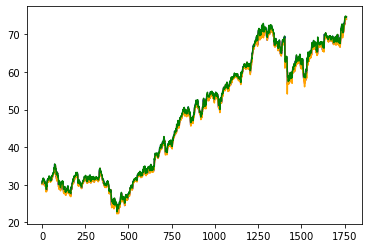

In [90]:
print(type(company_prices['ALB']))
company_output =company_prices['ALL'][:,2:6]

plt.plot(np.arange(len(company_output)),company_output[:,0]  ,color = 'red')
plt.plot(np.arange(len(company_output)) , company_output[:,1] ,color = 'blue')
plt.plot(np.arange(len(company_output)) , company_output[:,2] ,color = 'orange')
plt.plot(np.arange(len(company_output)), company_output[:,3] ,color = 'green')
plt.show()

In [91]:

print(company_prices['A'])

[['2010-01-04' 'A' 22.453504291799998 ... 22.2675250358
  22.625179542199998 3815500.0]
 ['2010-01-05' 'A' 22.324748926999998 ... 22.002861230300002
  22.3319034335 4186000.0]
 ['2010-01-06' 'A' 22.067239628000003 ... 22.002861230300002
  22.174535765399998 3243700.0]
 ...
 ['2016-12-28' 'A' 46.509997999999996 ... 45.68 46.700001 1177300.0]
 ['2016-12-29' 'A' 45.68 ... 45.57 46.0 891000.0]
 ['2016-12-30' 'A' 45.759997999999996 ... 45.380001 45.82 1216100.0]]


In [92]:
for key in company_prices.keys():
    date = company_prices[key][0,0];
    prev_date=list(map(int,date.split('-')))
    for date in company_prices[key][1:,0]:
        date = list(map(int,date.split('-')))
        if ((prev_date[2]<date[2]) and (prev_date[1]==date[1]) and (prev_date[0]==prev_date[0])) or((prev_date[2]>date[2]) and (prev_date[1]<date[1]) and (prev_date[0]==prev_date[0])) or((prev_date[2]>date[2]) and (prev_date[1]>date[1]) and (prev_date[0]<date[0])):
            prev_date = date
        else :
            prev_date=date
            print(date , prev_date)
            print(key  , 'fail')
            break

In [93]:
def data_preprocessing(prices,key, seq_len):
    data = np.array(prices[key][:,2:6])
    data = np.array(data ,dtype  = np.int32)
    data = (data - np.mean(data , axis =0))/np.std(data , axis=0)
    data = (data - np.min(data , axis = 0))/(np.max(data , axis =0)-np.min(data , axis = 0))
    x = []
    y = []
    for i in range(len(data)-seq_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    prices[key] =[x,y]
    return prices
seq_len=20
prices = company_prices.copy()
for key in prices.keys():
    prices = data_preprocessing(prices ,key, seq_len =20)

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Model

In [95]:
class CustomModel(Model):
    def __init__(self,**kwargs):
        super(CustomModel , self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(input_dim  = 502 , output_dim=32)
        self.gru1 = tf.keras.layers.GRU(units = 32 , return_state = True)
        self.dense= tf.keras.layers.Dense(units = 4 , activation ='sigmoid')
    def call(self,company_names , inputs ):
        embed_vector = self.embedding(company_names)
        embed_vector = tf.squeeze(embed_vector , axis = 1)
        #print(inputs.shape , embed_vector.shape)
        gru_output,cell_state = self.gru1(inputs , initial_state=[embed_vector])
        output = self.dense(gru_output)
        return output

In [96]:
data = tf.random.uniform(shape =[16,19,1] , dtype = tf.float32)
company_names = tf.random.uniform(shape  = [16,1] ,maxval = 501 )
model = CustomModel()
output = model(company_names , data)
print(output.shape)

(16, 4)


In [97]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss_obj = tf.keras.losses.MeanSquaredError()


In [98]:
company_names ={}
company_names = {key:i+1 for i,key in enumerate(prices.keys())}
print(company_names)

{'A': 1, 'AAL': 2, 'AAP': 3, 'AAPL': 4, 'ABBV': 5, 'ABC': 6, 'ABT': 7, 'ACN': 8, 'ADBE': 9, 'ADI': 10, 'ADM': 11, 'ADP': 12, 'ADS': 13, 'ADSK': 14, 'AEE': 15, 'AEP': 16, 'AES': 17, 'AET': 18, 'AFL': 19, 'AGN': 20, 'AIG': 21, 'AIV': 22, 'AIZ': 23, 'AJG': 24, 'AKAM': 25, 'ALB': 26, 'ALK': 27, 'ALL': 28, 'ALLE': 29, 'ALXN': 30, 'AMAT': 31, 'AME': 32, 'AMG': 33, 'AMGN': 34, 'AMP': 35, 'AMT': 36, 'AMZN': 37, 'AN': 38, 'ANTM': 39, 'AON': 40, 'APA': 41, 'APC': 42, 'APD': 43, 'APH': 44, 'ARNC': 45, 'ATVI': 46, 'AVB': 47, 'AVGO': 48, 'AVY': 49, 'AWK': 50, 'AXP': 51, 'AYI': 52, 'AZO': 53, 'BA': 54, 'BAC': 55, 'BAX': 56, 'BBBY': 57, 'BBT': 58, 'BBY': 59, 'BCR': 60, 'BDX': 61, 'BEN': 62, 'BHI': 63, 'BIIB': 64, 'BK': 65, 'BLK': 66, 'BLL': 67, 'BMY': 68, 'BSX': 69, 'BWA': 70, 'BXP': 71, 'C': 72, 'CA': 73, 'CAG': 74, 'CAH': 75, 'CAT': 76, 'CB': 77, 'CBG': 78, 'CBS': 79, 'CCI': 80, 'CCL': 81, 'CELG': 82, 'CERN': 83, 'CF': 84, 'CFG': 85, 'CHD': 86, 'CHK': 87, 'CHRW': 88, 'CHTR': 89, 'CI': 90, 'CINF': 9

In [99]:
model=CustomModel()

In [100]:
def grad(model , company_name , x,y ,loss_obj,batch_size=32):
    with tf.GradientTape() as tape:
        company_name=np.tile([company_name],[batch_size,1])
        output = model( company_name, x)
        loss = loss_obj(y_true = y , y_pred = output)
        grads = tape.gradient(loss , model.trainable_variables)
    return grads,loss,output

In [101]:
def show_company_graph(company_name , company_output):
    print(company_name)
    company_output = np.array(company_output).reshape([-1,4])
    plt.plot(np.arange(len(company_output)),company_output[:,0]  ,color = 'red')
    plt.plot(np.arange(len(company_output)) , company_output[:,1] ,color = 'blue')
    plt.plot(np.arange(len(company_output)) , company_output[:,2] ,color = 'orange')
    plt.plot(np.arange(len(company_output)), company_output[:,3] ,color = 'green')
    plt.show()

epoch: 0 WARNING:tensorflow:Layer gru_5 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

A


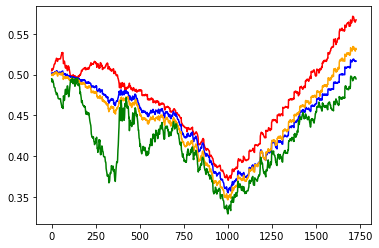

AAL


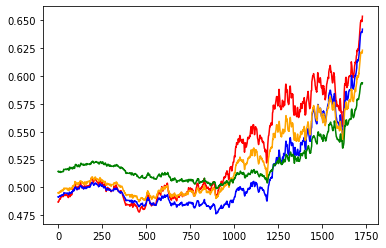

AAP


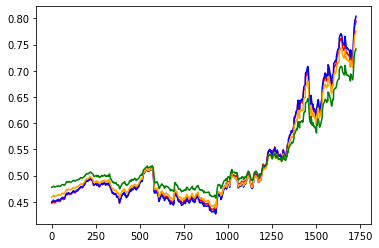

AAPL


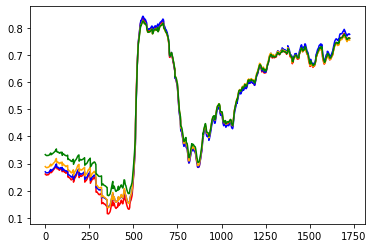

ABBV


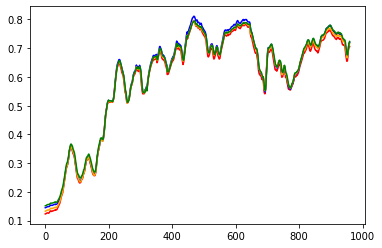

ABC


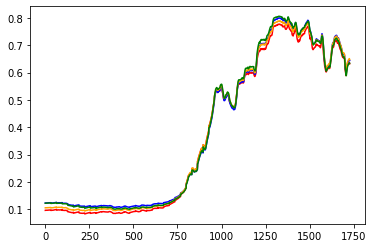

ABT


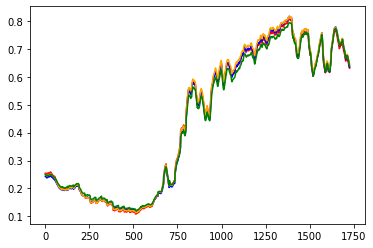

ACN


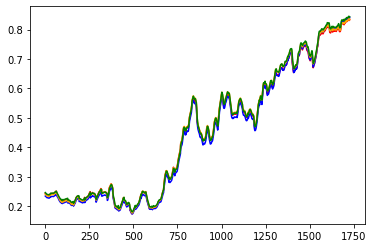

ADBE


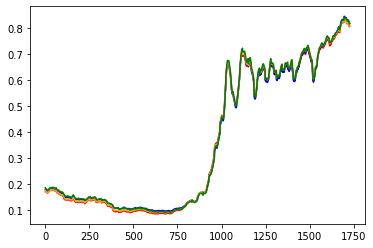

ADI


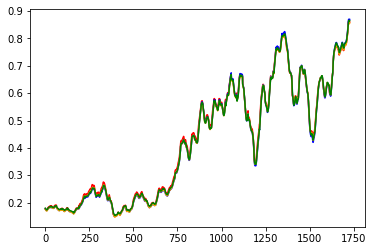

ADM


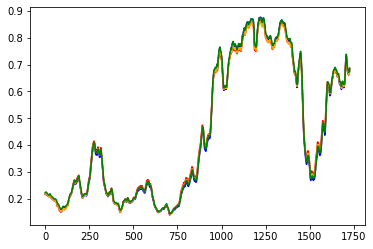

ADP


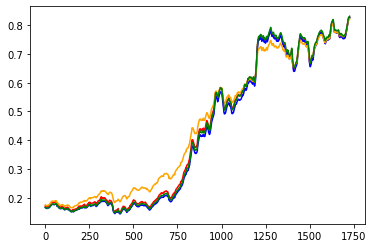

ADS


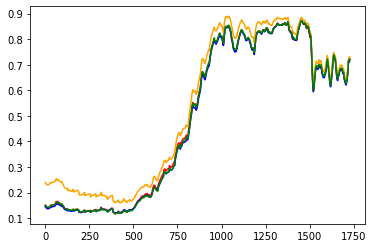

ADSK


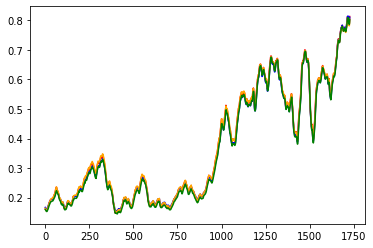

AEE


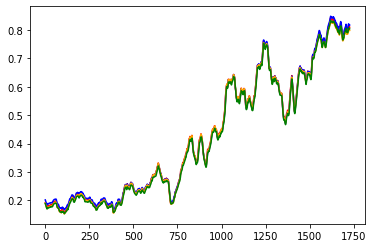

AEP


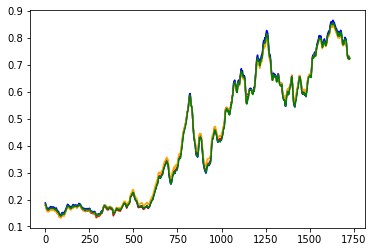

AES


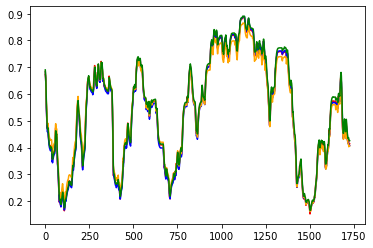

AET


ValueError: ignored

In [102]:
batch_size = 32
epochs=10
for epoch in range (epochs):
    epoch_loss=0
    print("epoch:" , epoch , end=' ')
    for key in prices.keys():
        num_batches = len(prices[key][0])//batch_size
        company_loss=0
        company_output=[]
        for j in range(num_batches):
            x = np.array(prices[key][0][j*batch_size : (j+1)*batch_size])
            y = np.array(prices[key][1][j*batch_size : (j+1)*batch_size])
            grads,loss,output= grad(model,company_names[key],x,y,loss_obj)
            optimizer.apply_gradients(zip(grads , model.trainable_variables))
            company_loss+=loss
            company_output.append(output)
        company_loss = company_loss/num_batches
        epoch_loss+=company_loss
        show_company_graph(key,company_output)
    epoch_loss = epoch_loss/len(prices.keys())
    print(epoch_loss)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
company_output = np.array(company_output).reshape([-1,4])
print(company_output.shape)

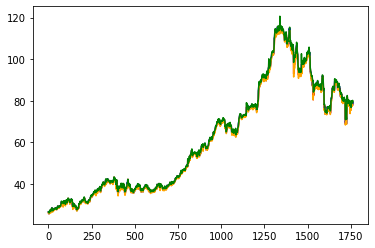

In [104]:
company_output =company_prices['ABC'][:,2:6]

plt.plot(np.arange(len(company_output)),company_output[:,0]  ,color = 'red')
plt.plot(np.arange(len(company_output)) , company_output[:,1] ,color = 'blue')
plt.plot(np.arange(len(company_output)) , company_output[:,2] ,color = 'orange')
plt.plot(np.arange(len(company_output)), company_output[:,3] ,color = 'green')
plt.show()